###Урок 3. Продвинутые архитектуры свёрточных нейросетей
##### Домашнее задание

Обучить СНС с помощью Transfer Learning на датасете Food-101 Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.applications import MobileNetV2

#### Загрузка датасета

In [2]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]', 'validation'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteKOK2SJ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteKOK2SJ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
# https://github.com/alpapado/food-101/blob/master/data/meta/labels.txt
labels = ['Apple pie','Baby back ribs','Baklava','Beef carpaccio','Beef tartare',
          'Beet salad','Beignets','Bibimbap','Bread pudding','Breakfast burrito',
          'Bruschetta','Caesar salad','Cannoli','Caprese salad','Carrot cake',
          'Ceviche','Cheesecake','Cheese plate','Chicken curry','Chicken quesadilla',
          'Chicken wings','Chocolate cake','Chocolate mousse','Churros',
          'Clam chowder','Club sandwich','Crab cakes','Creme brulee','Croque madame',
          'Cup cakes','Deviled eggs','Donuts','Dumplings','Edamame','Eggs benedict',
          'Escargots','Falafel','Filet mignon','Fish and chips','Foie gras','French fries',
          'French onion soup','French toast','Fried calamari','Fried rice','Frozen yogurt',
          'Garlic bread','Gnocchi','Greek salad','Grilled cheese sandwich','Grilled salmon',
          'Guacamole','Gyoza','Hamburger','Hot and sour soup','Hot dog','Huevos rancheros',
          'Hummus','Ice cream','Lasagna','Lobster bisque','Lobster roll sandwich',
          'Macaroni and cheese','Macarons','Miso soup','Mussels','Nachos','Omelette',
          'Onion rings','Oysters','Pad thai','Paella','Pancakes','Panna cotta',
          'Peking duck','Pho','Pizza','Pork chop','Poutine','Prime rib',
          'Pulled pork sandwich','Ramen','Ravioli','Red velvet cake','Risotto',
          'Samosa','Sashimi','Scallops','Seaweed salad','Shrimp and grits',
          'Spaghetti bolognese','Spaghetti carbonara','Spring rolls','Steak',
          'Strawberry shortcake','Sushi','Tacos','Takoyaki','Tiramisu','Tuna tartare',
          'Waffles']
num_classes = len(labels)


#### Визуализация датасета

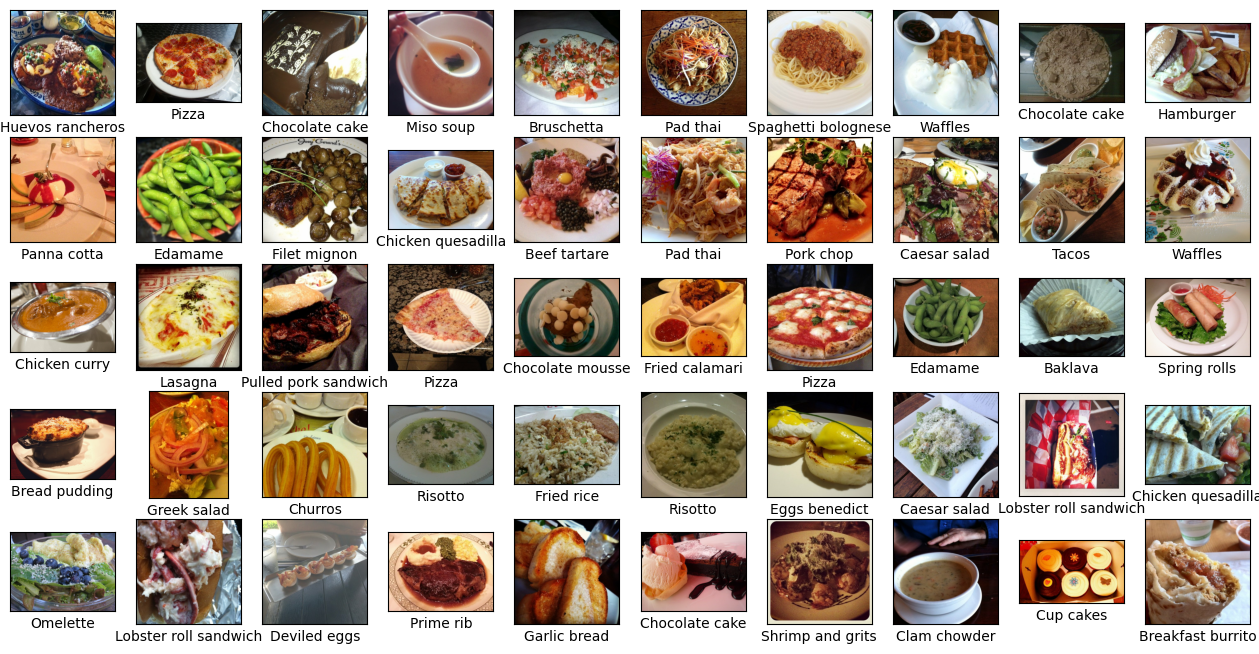

In [5]:
some_samples = [x for x in iter(train_ds.take(50))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(5, 10, j+1)
    ax.imshow(some_samples[j][0])
    plt.xticks([]), plt.yticks([])
    plt.xlabel(labels[some_samples[j][1]])
plt.show()

#### Создание пайплайна данных

In [14]:
INP_SIZE = 224
BATCH_SIZE = 32

def prepare(img, label):
  img = tf.cast(img, tf.float32)/127. - 1.
  return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.map(prepare)
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

###CNN c аугментацией

#### Подготовка модели CNN

In [7]:
img_augmentation = Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])


base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

inputs = layers.Input(shape=(INP_SIZE, INP_SIZE, 3))
x = img_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# fix train, do not learn first layers
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


#### Подготовка к обучению

In [8]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    name='sparse_categorical_crossentropy'
)

model.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381

#### Обучение модели

In [10]:
%%time

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[early_stopping])

Epoch 1/20
2130/2130 [==============================] - 277s 124ms/step - loss: 3.3977 - accuracy: 0.2380 - val_loss: 2.6127 - val_accuracy: 0.3624
Epoch 2/20
2130/2130 [==============================] - 241s 111ms/step - loss: 3.0430 - accuracy: 0.3054 - val_loss: 2.6284 - val_accuracy: 0.3602
Epoch 3/20
2130/2130 [==============================] - 256s 118ms/step - loss: 2.9797 - accuracy: 0.3165 - val_loss: 2.5128 - val_accuracy: 0.3832
Epoch 4/20
2130/2130 [==============================] - 257s 119ms/step - loss: 2.9542 - accuracy: 0.3218 - val_loss: 2.5150 - val_accuracy: 0.3859
Epoch 5/20
2130/2130 [==============================] - 255s 118ms/step - loss: 2.9433 - accuracy: 0.3271 - val_loss: 2.4889 - val_accuracy: 0.3918
Epoch 6/20
2130/2130 [==============================] - 255s 117ms/step - loss: 2.9227 - accuracy: 0.3301 - val_loss: 2.5614 - val_accuracy: 0.3814
Epoch 7/20
2130/2130 [==============================] - 254s 117ms/step - loss: 2.9279 - accuracy: 0.3311 - val_

#### Оценка качества модели

In [15]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 76s 352ms/step - loss: 5.5898 - accuracy: 0.0099
CPU times: user 2min, sys: 4.88 s, total: 2min 5s
Wall time: 1min 22s


[5.58975076675415, 0.009874682873487473]